## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

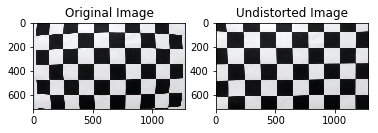

In [1]:
from find_lane import *
%matplotlib qt
%matplotlib inline 

# Calibrate using checkerboard
calib_imgs = glob.glob('./camera_cal/*.jpg')
example_img = cv2.imread(calib_imgs[0])
img_size = (example_img.shape[1], example_img.shape[0])

objpoints, imgpoints = find_obj_img_point_pairs(calib_imgs, 9, 6)
camera_matrix, dist_coeffs = calibrate(objpoints, imgpoints, img_size)

# Show undistort example
example_undistorted = cv2.undistort(example_img, camera_matrix, dist_coeffs, None, camera_matrix)

plt.subplot(1, 2, 1)
plt.imshow(example_img)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(example_undistorted)
plt.title("Undistorted Image")